# Neural Network MARS

References for this algorithm : 

Article [1] (English) : Adaptive splines-based logistic regression with a ReLU neural network, Marie Guyomard, Susana Barbosa, Lionel Fillatre, JOBIM, 2022. ⟨hal-03778323⟩ 

Article [2] (French) : Régression logistique à base de splines adaptatives avec un réseau de neurones ReLU, Marie Guyomard, Susana Barbosa, Lionel Fillatre, GRETZSI, 2022. ⟨hal-03778328⟩

**Table of contents**

This notebook provides the following methods :
- A class functions for NN-MARS
- A class functions to compute the accuracies of the NN-MARS : global accuracy, accuracies per class and AUC
- A class functions to plot the splines estimated per variable by the NN-MARS
- A function to train the NN-MARS with cross-validation
- A function in order to check the convergence of the NN-MARS during its training process
- A class function to plot the decision boundary

## Required Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.utils import class_weight
import time
import math
import os
import random
from tqdm import tqdm, trange
import statistics
from IPython import display

## Class for NN-MARS

The above algorithm is available here for **binary** classification problems. 

Let suppose we have $N$ independant and identically distributed pairs $\{x^{(i)}, y^{(i)}\}_{i=1}^{N}$. We consider the following neural network :

$$f(x) = \hat{\mathbb{P}}\left(Y=1|X\right) = \sigma(\psi_X(\theta)).$$
	

with 

$$\sigma = \frac{1}{1+\exp(-X)} $$
and 
$$\psi_X(\theta) = \beta_0 + \beta \phi\left(\bar{W}X^T+b\right).$$

such as

$\phi(X) = \text{ReLU}(X) = \max\{0,X\} \\
X \in\mathbb{R}^{N \times d} \\
b = [b_{11}, b_{12}, \dots, b_{d1}, b_{d2}]^T \in \mathbb{R}^{2d} \\
\beta = [\beta_{11}, \beta_{12}, \dots, \beta_{d1}, \beta_{d2}] \in \mathbb{R}^{2d} \\
\bar{W} = \begin{bmatrix}
		-1 & 0 & \dots & 0 \\
		1 & 0 & \dots & 0 \\
		0 & -1 & \dots & 0 \\
		0 & 1 & \dots & 0 \\
	\end{bmatrix} \in \mathbb{R}^{2d \times d} \\
\theta = [\beta_0, \beta, b^T]^T = [\beta_0, \beta_1, \dots, \beta_d, b_1, \dots, b_p]^T 
$

*Remark : for binar categorical variable, only one node is created.*

**Scheme of the model**

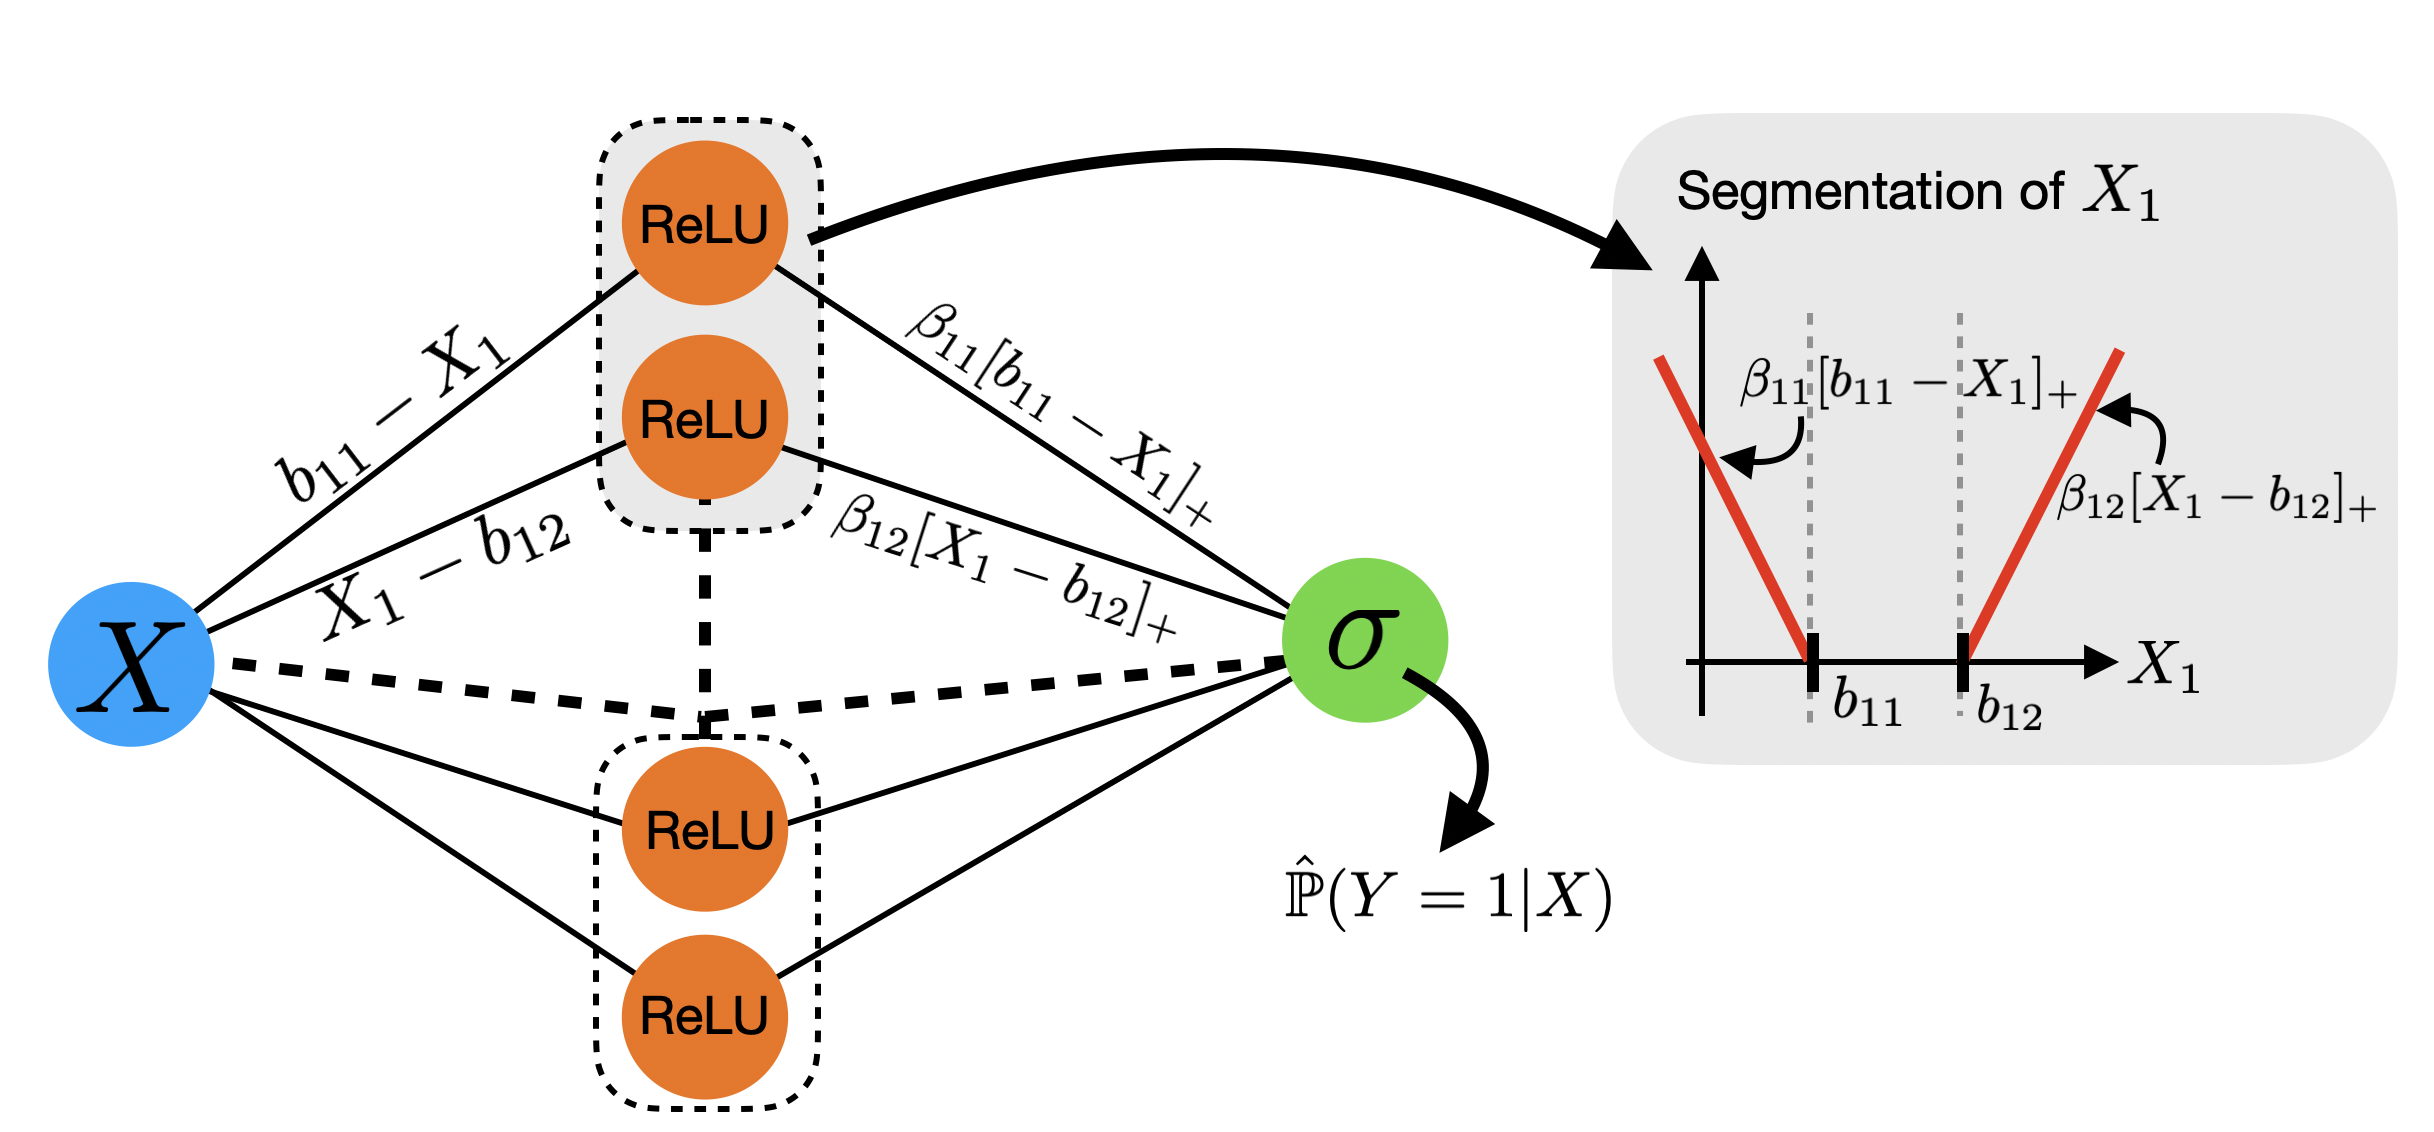

In [7]:
display.Image('Schema_NNMARS.png', width=2000)

In [ ]:
class NeuralNetwork_MARS(nn.Module):
    
    '''
    This class function creates and estimates NN-MARS.
    
    Methods:
        forward : creates NN-MARS
        backward : predicts NN-MARS
        training_step : trains NN-MARS
        testing_step : evaluates generalization of NN-MARS
    '''
    
    def __init__(self, X):
        '''
        Parameters
        ----------
        X : DataFrame
            Features.
        Returns
        -------
        None.

        '''
        super(NeuralNetwork_MARS, self).__init__()
        
        self.X = X 
        self.nb_nodes = 0
        for i in range(self.X.shape[1]):
            if len(np.unique(np.array(self.X[self.X.columns.tolist()[i]]))) !=2 :
                self.nb_nodes += 2
            else :
                self.nb_nodes += 1



        self.input_layer = nn.Linear(self.X.shape[1], self.nb_nodes)
        self.output_layer = nn.Linear(self.nb_nodes, 1)
        self.sigmoide = nn.Sigmoid()
       
       
    def forward(self, input_data, dropout_rate):
        '''
        Parameters
        ----------
        input_data : Tensor
            Features.
        dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate.

        Returns
        -------
        predictions : tensor
            Output of the neural network.

        '''
        
        d = self.X.shape[1]
        
        # Initializations
        a = torch.zeros(self.nb_nodes, d, requires_grad=False)
        j = 0
        for i in range(self.X.shape[1]):
            if len(np.unique(np.array(self.X[self.X.columns.tolist()[i]]))) !=2 :
                a[j][i]=-1
                a[j+1][i]=1
                j+=2
            else :
                a[j][i]=1
                j+=1
           
        self.input_layer.weight = torch.nn.Parameter(a, requires_grad=False) 
        self.input_layer.weight = torch.nn.Parameter(a, requires_grad=False) 
        output = self.input_layer(input_data)
        output = F.relu(output)
        
        if dropout_rate != 0 :
            output = self.dropout(output)
        
        # Get predictions
        output = self.output_layer(output)
        predictions = self.sigmoide(output)
        
        return predictions
        
    

    def backward(self, optimizer, loss):
        '''
        Parameters
        ----------
        optimizer : torch.optim
            Optimization algorithm.
        loss : tensor
            Loss.
    
        Returns
        -------
        None.
    
        '''
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    
    def training_step(self, Xtrain, Ytrain, option_balanced, dropout_rate, learning_rate, K):
        '''
        Parameters
        ----------
        Xtrain : Tensor
            Features of the training sample.
        Ytrain : Tensor
            Labels of the training sample.
        option_balanced : boolean
            True ; balanced binary cross entropy loss. False ; binary cross entropy loss.
        dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate.
        learning_rate : float
            Learning rate.
        K : int
            Number of classes.
    
        Returns
        -------
        loss : tensor
            Loss.
        piTrain : array
            Class proportions of the training sample.
        RTrain : array
            Conditional risks on the training sample.
        rTrain : float
            Empirical risk on the training sample.
        auc : float
            AUC on the testing sample
        '''
        
        # Predictions
        Proba_train = self.forward(Xtrain.float(), dropout_rate) 

    
        Yhat_train = []
        for i in range(len(Proba_train.detach().numpy())):
            if Proba_train.detach().numpy()[i] >= 0.5 :
                Yhat_train.append(int(1))
            else :
                Yhat_train.append(int(0))
                          
                
        # Loss
        if option_balanced == True :
            reponderation = torch.Tensor(class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(np.array(Ytrain)), y = np.array(Ytrain)))
            weights = torch.Tensor(np.zeros(Ytrain.shape[0]))
            for i in range(Ytrain.shape[0]) :
                if Ytrain[i]==0 :
                    weights[i]=reponderation[0] 
                else :
                    weights[i]=reponderation[1] 
            loss = nn.BCELoss(weight=weights)(Proba_train.view(Xtrain.shape[0]), Ytrain.float())
        else :
            loss = nn.BCELoss()(Proba_train.view(Xtrain.shape[0]), Ytrain.float())

        optimizer = optim.SGD([{'params': self.input_layer.bias}, 
                               {'params': self.output_layer.parameters()}], lr=learning_rate)

    
    
        self.backward(optimizer, loss)
        
        # Accuracies 
        outil_performance = performances_NeuralNetwork(K, Ytrain, Yhat_train)
        piTrain = outil_performance.compute_pi()
        RTrain, confTrain = outil_performance.compute_conditional_risk()
        rTrain = outil_performance.compute_global_risk(piTrain, RTrain)
        aucTrain = outil_performance.compute_auc(Ytrain, Proba_train)
        
        return loss, RTrain, rTrain, aucTrain   
        
    
    def validation_step(self, Xtest, Ytest, option_balanced, dropout_rate, K):
        '''
        Parameters
        ----------
        Xtest : Tensor
            Features of the testing sample.
        Ytest : Tensor
            Labels of the testing sample.
        optimizer : torch.optim
            Optimization algorithm.
        option_balanced : boolean
            True ; balanced binary cross entropy loss. False ; binary cross entropy loss.
        dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate.
        K : int
            Number of classes.
            
        Returns
        -------
        loss : tensor
            Loss.
        piTest : array
            Class proportions of the testing sample.
        RTest : array
            Conditional risks on the testing sample.
        rTest : float
            Empirical risk on the testing sample.
        auc : float
            AUC on the testing sample
        '''
    
       	# Predictions
       	Proba_test = self.forward(Xtest.float(), dropout_rate) 
       	
        Yhat_test = []
        for i in range(len(Proba_test.detach().numpy())):
            if Proba_test.detach().numpy()[i] >= 0.5 :
                Yhat_test.append(int(1))
            else :
                Yhat_test.append(int(0))
                
       	# Loss
        if option_balanced == True :
            reponderation = torch.Tensor(class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(np.array(Ytest)), y = np.array(Ytest)))
            weights = torch.Tensor(np.zeros(Ytest.shape[0]))
            for i in range(Ytest.shape[0]) :
                if Ytest[i]==0 :
                    weights[i]=reponderation[0] 
                else :
                    weights[i]=reponderation[1] 
            loss = nn.BCELoss(weight=weights)(Proba_test.view(Xtest.shape[0]), Ytest.float())
        else :
       	    loss = nn.BCELoss()(Proba_test.view(Xtest.shape[0]), Ytest.float())
       
       	# Accuracies
        outil_performance = performances_NeuralNetwork(K, Ytest, Yhat_test)
        piTest = outil_performance.compute_pi()
        RTest, confTest = outil_performance.compute_conditional_risk()
        rTest = outil_performance.compute_global_risk(piTest, RTest)
        aucTest = outil_performance.compute_auc(Ytest, Proba_test)
    
        return loss, RTest, rTest, aucTest

## Class of Accuracies for NN-MARS

Compute :
- Conditional risks
- Global rsik
- AUC

In [ ]:
class performances_NeuralNetwork():
    
    '''
    This class of function compute various diagnostics of accuracy of NN-MARS.
    
    Methods :
        compute_pi : computes class proportions
        compute_conditional_risk : computes conditional risks (1 - accuracy per class)
        compute_global_risk : computes global risk (1 - accuracy)
        compute_auc : computes AUC.
    '''
    
    
    def __init__(self, K, Y, Yhat):
        '''
        Parameters
        ----------
        K : int
            Number of classes.
        Y : DataFrame
            Real labels.
        Yhat : list
            Estimated labels.
            
        '''

        super(performances_NeuralNetwork, self).__init__()
        
        self.K = K
        self.Y = Y
        self.Yhat = Yhat
        
        
    def compute_pi(self):
        '''
        Returns
        -------
        pi : array
            Array of class proportions.

        '''

        pi = np.zeros((1,self.K))
        YR_liste = self.Y.tolist()
        for k in range(0, self.K):
            pi[0,k] = YR_liste.count(k)/np.shape(YR_liste)[0]
        return pi


    def compute_conditional_risk(self): 
        '''
        Returns
        -------
        R : array
            Conditionnal risks.
        confmat : matrix
            Confusion matrix.

        '''
        
        confmat = np.zeros((self.K, self.K))
        R = np.zeros((1, self.K))
        YR_liste = self.Y.tolist()
        L = np.ones((self.K,self.K)) - np.eye(self.K,self.K)
        for k in range(0, self.K):
            mk = YR_liste.count(k)
            if mk > 0:
                Ik = np.where(self.Y == (k))
                for l in range(0, self.K):
                    confmat[k,l] = sum(np.array(self.Yhat)[Ik[0]]==l)/mk
            R[0,k] = L[k, :].dot(confmat[k, :]) 
        return R, confmat


    def compute_global_risk(self, pi, R):
        '''
        Parameters
        ----------
        pi : array
            Array of class proportions.
        R : array
            Conditionnal risks.

        Returns
        -------
        r : float
            Empirical risk.
        '''
        
        r = (pi[0].dot(R[0]))
        return r
    
    
    
    def compute_auc(self, Y, Proba):
        
        fp_rate, tp_rate, thresholds = metrics.roc_curve(Y, Proba.detach().numpy())
        val_auc = metrics.auc(fp_rate, tp_rate)
        return val_auc

## Function to plot the estimated splines

In [ ]:
def NNMARS_plot_splines(X, model, figsize=(5,5), Save_Fig=False, path=[]):

    '''
    This function plots the estimated splines by NN-MARS.
    
    Parameters:
    -----------
    X: DataFrame
        Features.
    model: NeuralNetwork_MARS
        Parameters of the NN-MARS to use.
    figsize: List
        Size of the figure.
        Default : (5,5).
    Save_Fig: boolean
        If True the figure is saved.
        Default : False.
    path: str
        Path were to save the figure if Save_Fig = True.
        Default : [].

    Returns:
    --------
    None.
        
    '''



    f_NNMARS = []

    j=0
    for var in X.columns.tolist() :

        seq = np.arange(X[str(var)].min(), X[str(var)].max(), 0.0001)
        f = np.zeros(len(seq))

        if len(np.unique(np.array(X[str(var)]))) !=2 :
            for i in range(len(seq)) :
                f[i] += model.state_dict()['output_layer.weight'][0][j]*max(0,model.state_dict()['input_layer.bias'][j]-seq[i]) +  model.state_dict()['output_layer.weight'][0][j+1]*max(0,seq[i]-model.state_dict()['input_layer.bias'][j])
            f_NNMARS.append(f) 
        
            plt.figure(figsize=figsize)
            plt.plot(seq, f, color='red', lw=2)
            plt.vlines(model.state_dict()['input_layer.bias'][j], ymin=np.min(f), ymax=np.max(f), lw=2, ls='--', color='gray')
            plt.vlines(model.state_dict()['input_layer.bias'][j+1], ymin=np.min(f), ymax=np.max(f), lw=2, ls='--', color='gray')
            plt.xlabel(var)
            if Save_Fig == True :
                plt.savefig(path+"Spline_"+str(var)+'.pdf')

            j+=2

        else :
            for i in range(len(seq)) :
                f[i] += model.state_dict()['output_layer.weight'][0][j]*max(0,model.state_dict()['input_layer.bias'][j]-seq[i]) 
            f_NNMARS.append(f) 

            plt.figure(figsize=figsize)
            plt.plot(seq, f, color='red', lw=2)
            plt.vlines(model.state_dict()['input_layer.bias'][j], ymin=np.min(f), ymax=np.max(f), lw=2, ls='--', color='gray')
            plt.xlabel(var)
            if Save_Fig == True :
                plt.savefig(path+"Spline_"+str(var)+'.pdf')

            j+=1

## Function for Cross Validation of NN-MARS

In [ ]:
def NNMARS_CrossValidation(X, Y, nb_folds, learning_rate, epoch, early_stopping, option_balanced, dropout_rate) :
    '''
    
    This function realizes a cross-validation to train NN-MARS.
    
    Parameters
    ----------
    X : DataFrame
        Features.
    Y : List
        Labels.
    nb_folds : int
        Number of folds for the cross validation.
    learning_rate : float
        Hyperparameter: learning rate.
    epoch : int
        Number of iterations to train the Neural Network.
    early_stopping : bool
        True if early stopping.
    option_balanced : boolean
        True ; balanced binary cross entropy loss. False ; binary cross entropy loss.
    dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate.
    
    Returns
    -------
    df_iter : DataFrame
        Accuracies per fold.
    res_mean : DataFrame
        Means of the accuracies.
    res_std : DataFrame
        Standard deviations of the accuracies.
    times_fold : list
        Times per fold.
    times : DataFrame
        Mean and standard deviation of the times per fold.
    models : list
        Model per epoch.
    '''
    
    df_iter = pd.DataFrame()
    
    times_fold = []
    times = pd.DataFrame()
    
    models = []
    
    d = X.shape[1]
    K = len(np.unique(Y))

    for i in tqdm(range(nb_folds)):

        # Split Train / Test
        Xtrain, Xtest, y_train, y_test = train_test_split(X, Y, test_size=0.3)

        # Normalization of the data
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
        scaler.fit(Xtrain)
        X_train = pd.DataFrame(scaler.transform(Xtrain), columns = X.columns)
        X_test = pd.DataFrame(scaler.transform(Xtest), columns = X.columns)


        # Tensor
        X_tensor_train = torch.tensor(X_train.values, )
        YR_tensor_train= torch.tensor(np.array(y_train), requires_grad=False).view(len(y_train))
        X_tensor_test = torch.tensor(X_test.values, )
        YR_tensor_test= torch.tensor(np.array(y_test), requires_grad=False).view(len(y_test))


        # Output lists
        list_loss_train, list_RTrain, list_rTrain, list_auc_train = [], [], [], []
        list_loss_test, list_RTest, list_rTest, list_auc_test = [], [], [], []


        # Construction of the Model
        start_fold = time.time()
        NNMARS = NeuralNetwork_MARS(X=X)  


        # Entraînement du modèle
        for it in range(epoch) :

            loss_train, RTrain, rTrain, auc_train = NNMARS.training_step(X_tensor_train, YR_tensor_train, option_balanced, dropout_rate, learning_rate, K)
            loss_test, RTest, rTest, auc_test = NNMARS.validation_step(X_tensor_test, YR_tensor_test, option_balanced, dropout_rate, K)
            
            if early_stopping == True :
                if it>1:
                    if list_loss_test[-1]<loss_test:
                        break

            list_loss_train.append(loss_train.data.detach().numpy().item())
            list_RTrain.append(RTrain)
            list_rTrain.append(rTrain)
            list_auc_train.append(auc_train)

            list_loss_test.append(loss_test.data.detach().numpy().item())
            list_RTest.append(RTest)
            list_rTest.append(rTest)
            list_auc_test.append(auc_test)

            #print(str(it) + '- Loss on train : ' + str(round(loss_train.data.detach().numpy().item(),2)) + ' - rTrain : ' + str(rTrain )+ ' - RTrain : ' + str(RTrain) + ' - AUC train :' + str(auc_train) + "\n "+ '- rTest : ' + str(rTest) + ' - RTest :' + str(RTest) + ' - AUC test :' + str(auc_test))    

            it+=1

        end_fold = time.time()
        times_fold.append(end_fold - start_fold)
        
        models.append(NNMARS)
        
        # Accuracies
        df_iter.loc[str(i), 'acc_train'], df_iter.loc[str(i), 'acc1_train'],df_iter.loc[str(i), 'acc2_train'],df_iter.loc[str(i), 'auc_train'],df_iter.loc[str(i), 'acc_test'],df_iter.loc[str(i), 'acc1_test'],df_iter.loc[str(i), 'acc2_test'],df_iter.loc[str(i), 'auc_test'] = 1-rTrain, 1-RTrain[0][0], 1-RTrain[0][1], auc_train, 1-rTest, 1-RTest[0][0], 1-RTest[0][1], auc_test


        # Convergence Diagnostic
        diag_convergence(list_loss_train, list_auc_train, list_rTrain, list_RTrain)
        diag_convergence(list_loss_test, list_auc_test, list_rTest, list_RTest)


    # Mean Results
    res_mean = df_iter.mean()
    res_std = df_iter.std()


    # Print Results
    print('Performances par itération :')
    print(df_iter)  
    print('Performance moyenne :')
    print(res_mean)

    times['mean'], times['std'] = [statistics.mean(times_fold)], [statistics.stdev(times_fold)]
    
    return df_iter, res_mean, res_std, times_fold, times, models

## Convergence of the Neural Network Diagnostic

In [ ]:
def diag_convergence(loss, auc, risk, risk_cond):
    '''
    
    This function plots various diagnostics of convergence : loss, auc, global accuracie 
    and accuracies per class according to iterations.
    
    Parameters
    ----------
    loss : list
        Loss at each iteration.
    auc : list
        AUC at each iteration.
    risk : list
        Risk at each iteration.
    risk_cond : list
        Conditionnal risk at each iteration.

    Returns
    -------
    None. Plot
    '''
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    axs[0, 0].plot(np.arange(0,np.array(loss).shape[0]),loss, c='blue')
    axs[0, 0].set_title("Loss")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_label("Loss")

    axs[1, 0].plot(np.arange(0,np.array(auc).shape[0]),  auc, c='green')
    axs[1, 0].set_title("AUC")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("AUC")
    axs[1, 0].set_ylim((0,1))

    axs[0, 1].plot(np.arange(0,np.array(risk).shape[0]),np.ones(np.array(risk).shape[0]) - risk, c='red')
    axs[0, 1].set_title("Accuracy")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].set_ylim((0,1))

    colors = ['darkviolet', 'orangered']
    labels = []
    for k in range(np.shape(risk_cond)[2]):
        liste_R = [xi[0][k] for xi in risk_cond]
        axs[1, 1].plot(np.arange(0,np.array(liste_R).shape[0]),np.ones(np.array(liste_R).shape[0])-liste_R, c=colors[k])
        labels.append('Classe'+str(k+1))
    axs[1, 1].legend(labels)
    axs[1, 1].set_title("Conditionnal accuracies")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("Accuracy")

## Plot of the decision rule

Remarks : this function works for binary classification problem with only 2 features.

This method was inspired by the work of Randall Balestriero concerning the vizualisation of splines estimated in deep networks provided here : https://github.com/RandallBalestriero/spline-DN-visualization

In [ ]:
class Plot_partition_NN_MARS():
    
    '''
    This class of function plot the decision rule estimated by NN-MARS.
    Remark : this function works for binary classification problem with only 2 features ! 
    
    This method was inspired by the work of Randall Balestriero concerning the vizualisation 
    of splines estimated in deep networks provided here : 
    https://github.com/RandallBalestriero/spline-DN-visualization
        
    '''
    
    def __init__(self, X, Y, model, n_samples=300, figsize=(5,5), colors=['black', 'blue', 'green', 'orange'], Save_Fig=False, path=[]):
        '''
        Parameters:
        -----------
        X: DataFrame
            Features.
        Y: DataFrame
            Labels.
        model: NeuralNetwork_MARS
            Parameters of the NN-MARS to use.
        n_samples: int
            Number of samples to create in the meshgrid.  
            Defaut : 300.
        figsize: List
            Size of the figure.
            Default : (5,5).
        colors: List
            List of colors per layer to use.
            Default : ['black', 'blue', 'green', 'orange'].
        Save_Fig: boolean
            If True the figure is saved.
            Default : False.
        path: str
            Path were to save the figure if Save_Fig = True.
            Default : [].
    
        '''
        
        super(Plot_partition_NN_MARS, self).__init__()
        
        self.X = X
        self.Y = Y
        self.model = model
        self.n_samples = n_samples
        self.figsize = figsize
        self.colors = colors
        self.Save_Fig = Save_Fig
        self.path = path


    def meshgrid(self):
        '''
        Returns
        -------
        meshgrid : Array
            Meshgrid.
        dn_input : Array
            Means of the accuracies.
        '''
        
        self.extent = [np.min(self.X.iloc[:,0]), np.max(self.X.iloc[:,0]), np.min(self.X.iloc[:,1]), np.max(self.X.iloc[:,1])]
        x1 = np.linspace(self.extent[0], self.extent[1], self.n_samples)
        x2 = np.linspace(self.extent[2], self.extent[3], self.n_samples)
        meshgrid = np.meshgrid(x1, x2)
        dn_input = np.stack([meshgrid[0].reshape(-1), meshgrid[1].reshape(-1)], 1)

        return meshgrid, dn_input


    def zero_set_paths(self, feature_maps, meshgrid):
        """
        Parameters:
        -----------
    
        feature_maps: nested list of matrices, same shape as flattened X or flattened Y
            each vector represents the output mapping of a specific
            neuron to compute the zero set from.
    
        meshgrid: couple of matrices (X, Y)
            the sampling of the input space used to generated the feature_maps
            vectors.
    
        Returns:
        --------
    
        vertices: list
            paths by nodes.
        """
    
        if type(feature_maps) == list:
            return [self.zero_set_paths(np.array(p), meshgrid) for p in feature_maps]
    
        paths = plt.contour(
            meshgrid[0], meshgrid[1], feature_maps.reshape(meshgrid[0].shape), [0]
        )
        paths = paths.collections[0].get_paths()
        plt.close()
    
        vertices = []
        for path in paths:
            clean_vertices = path.cleaned(simplify=True).vertices
            vertices.append(clean_vertices[:-1])

        return vertices

    

    def draw_layer_paths(self, ax, paths, colors):
      if type(paths) == list and type(colors) == list:
          assert len(paths) == len(colors)
          for p, c in zip(paths, colors):
              self.draw_layer_paths(ax, p, c)
      elif type(paths) == list and type(colors) != list:
          for p in paths:
              self.draw_layer_paths(ax, p, colors)
      else:
          if paths.shape[1] == 2:
              ax.plot(
                  paths[:, 0],
                  paths[:, 1],
                  c=colors,
                  )
          elif paths.shape[1] == 3:
              ax.plot(
                  paths[:-1, 0],
                  paths[:-1, 1],
                  paths[:-1, 2],
                  c=colors,
              )
              
     
        
    def figure_partition(self):
        
        layers = []
        paths = []
        
        meshgrid, dn_input = self.meshgrid()
        
        
        ## Input Layer
        layers.append(F.linear(torch.tensor(np.array(dn_input)).float(), self.model.input_layer.weight, self.model.input_layer.bias))
        layers.append(F.relu(layers[-1]))
    
        # Paths
        paths.append(self.zero_set_paths(feature_maps=np.transpose(layers[-1].data.numpy()).tolist(), meshgrid=meshgrid))
            
        # Figure
        fig = plt.figure(figsize=self.figsize)
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(self.X.iloc[np.where(np.array(self.Y)==0)[0], 0], self.X.iloc[np.where(np.array(self.Y)==0)[0], 1], edgecolor='dodgerblue', color='azure')
        plt.scatter(self.X.iloc[np.where(np.array(self.Y)==1)[0], 0], self.X.iloc[np.where(np.array(self.Y)==1)[0], 1], edgecolor='gold', color='lemonchiffon')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend(['Class 1', 'Class 2'])
        ax.set_xlim(self.extent[:2])
        ax.set_ylim(self.extent[2:])
        i=0
        for path in paths :
            for p in path :
                self.draw_layer_paths(ax, p, self.colors[i])
            i+=1
        if self.Save_Fig == True :
            plt.savefig(self.path+"/Partition_layer"+str(k+1)+'.pdf')
        plt.plot()
    
        ## Output layer
        score = F.linear(layers[-1], self.model.output_layer.weight, self.model.output_layer.bias)
        Phat = nn.Sigmoid()(score)
        Yhat_plot = []
        for i in range(len(Phat)):
            if  Phat[i]>= 0.5 :
                Yhat_plot.append(1.)
            else :
                Yhat_plot.append(0.)
        
            
        # Figure
        fig = plt.figure(figsize=self.figsize)
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(self.X.iloc[np.where(np.array(self.Y)==0)[0], 0], self.X.iloc[np.where(np.array(self.Y)==0)[0], 1], edgecolor='dodgerblue', color='azure')
        plt.scatter(self.X.iloc[np.where(np.array(self.Y)==1)[0], 0], self.X.iloc[np.where(np.array(self.Y)==1)[0], 1], edgecolor='gold', color='lemonchiffon')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend(['Class 1', 'Class 2'])
        ax.set_xlim(self.extent[:2])
        ax.set_ylim(self.extent[2:])
        i=0
        for path in paths :
            for p in path :
                self.draw_layer_paths(ax, p, self.colors[i])
            i+=1
        plt.contour(meshgrid[0], meshgrid[1], np.array(Yhat_plot).reshape(meshgrid[0].shape), colors='red', linewidths=1.5, linestyles='-')
        if self.Save_Fig == True :
            plt.savefig(self.path+"/Partition_layer"+str(k+1)+'.pdf')
        plt.plot()
          
        
        return meshgrid, Yhat_plot